# AR(1) processes and unit-root processes.

## Import packages and data

Import necessary packages.

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import math

import wrds
import fredapi

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from matplotlib import pyplot as plt

Import data from WRDS: S&P 500 returns, dividends, levels.

In [2]:
wrds_conn = wrds.Connection(wrds_username='ashelaine')

data = wrds_conn.raw_sql("select caldt, vwretd, vwretx, spindx, totval from crsp_a_indexes.msp500")
data['month'] = pd.to_datetime(data['caldt']).dt.to_period('M')
data = data.set_index(['month']).drop('caldt',axis=1)

# Calculate S&P 500 dividends as the difference between monthly return with and without dividends.
data['dividends'] = ( data['vwretd'] - data['vwretx'] )*data['spindx'].shift()

# Aggregate dataset to quarterly level.
dataq = data.reset_index()
dataq['quarter'] = dataq['month'].dt.to_timestamp().dt.to_period('Q')
dataq = dataq.set_index('quarter')
dataq['dividends2'] = dataq.groupby(level=0).dividends.sum()
dataq = dataq.groupby(level=0).last()

# dataq = dataq['1926Q1':]
dataq = dataq['1946':'2022']

Enter your WRDS username [ashelaine]:ashelaine
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


Calculate the series that we will actually use in the analysis

In [3]:
log_spindx = np.log(dataq['spindx'])
log_spindx_growth = log_spindx.diff().dropna()

log_dividends = np.log(dataq['dividends'])
log_dividends_growth = log_dividends.diff().dropna()

log_DP = np.log(dataq['dividends']/dataq['spindx'])

The code above calculates five different series, at a quarterly frequency, from 1946 to 2022:
1. The S&P 500 index level, measured as a logarithm.
2. The change in the above value (that is, the percentage increase in the S&P 500 index).
3. The dividends paid by S&P 500 stocks, as a logarithm.
4. The change in the above value (that is, the percentage growth of S&P 500 dividend payments).
5. The S&P 500 dividend yield (dividends as a fraction of index value), as a logarithm.

For each of the above series, plot them, and then conduct an ADF test and a KPSS test (allowing statsmodels to choose the optimal number of lags). 

Finally, for the last ADF test that you ran (on the dividend yield), show how the test statistic from this test can be located in the output from a regression with the statsmodels summary() command. Then explain why the p-value from the test is *not* located anywhere in the same regression output.

### Series No.1

ADF test results for S&P 500 index level:


(-0.21820230493173445,
 0.9363168851032068,
 0,
 307,
 {'1%': -3.4518314994261337,
  '5%': -2.8710009653519166,
  '10%': -2.571810878948318},
 -649.4008394406766)

KPSS test results for S&P 500 index level:


/var/folders/m5/g3lrdtg540gfc8q3_268l1800000gn/T/ipykernel_14261/2548355906.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  display(kpss(log_spindx))


(2.609602962528806,
 0.01,
 11,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

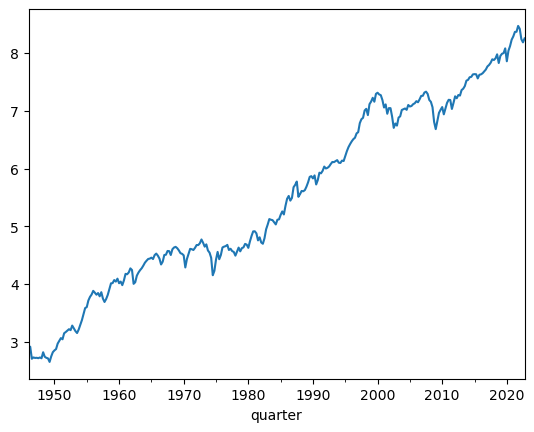

In [4]:
log_spindx.plot();
print("ADF test results for S&P 500 index level:")
display(adfuller(log_spindx))
print("KPSS test results for S&P 500 index level:")
display(kpss(log_spindx))

Firstly, the S&P 500 index level follows a random walk so that there is a strong trend in the plot. Besides, we see that the p-value in the ADF test is 0.94, which is greater than 0.05. That means we already believe the series has a unit root, and the computer confirms that we are right. The p-value in the KPSS test is 0.01, and the warning states that the actual p-value is smaller than the p-value returned. That indicates we already believe the data are stationary, but there is clear evidence to change our mind from the p-value is less than 0.01, which is also less than 0.05.

### Series No.2

ADF test results for the percentage increase in the S&P 500 index:


(-16.536197610353288,
 2.0028658879718758e-29,
 0,
 306,
 {'1%': -3.4519023023726696,
  '5%': -2.8710320399170537,
  '10%': -2.57182745012602},
 -646.6758417426311)

KPSS test results for the percentage increase in the S&P 500 index:


/var/folders/m5/g3lrdtg540gfc8q3_268l1800000gn/T/ipykernel_14261/4208244285.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  display(kpss(log_spindx_growth))


(0.04188610042460358,
 0.1,
 2,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

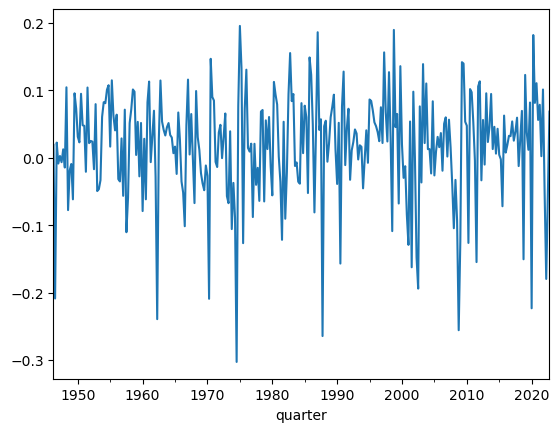

In [5]:
log_spindx_growth.plot();
print("ADF test results for the percentage increase in the S&P 500 index:")
display(adfuller(log_spindx_growth))
print("KPSS test results for the percentage increase in the S&P 500 index:")
display(kpss(log_spindx_growth))

Firstly, the percentage increase in the S&P 500 index level is stationary, so there is no trend in the plot. Besides, we see that the p-value in the ADF test is nearly 0, which is smaller than 0.05. That means we already believe the series has a unit root, but there is clear evidence to change our minds. The p-value in the KPSS test is 0.1, and the warning states that the actual p-value is greater than the p-value returned. That indicates we already believe the data are stationary, and the computer confirms that we are right from the p-value is greater than 0.1, which is also greater than 0.05.

### Series No.3

ADF test results for the dividends paid by S&P 500 stocks:


(0.15144635764690587,
 0.9694030497467285,
 7,
 300,
 {'1%': -3.4523371197407404,
  '5%': -2.871222860740741,
  '10%': -2.571929211111111},
 -365.88720660687375)

KPSS test results for the dividends paid by S&P 500 stocks:


/var/folders/m5/g3lrdtg540gfc8q3_268l1800000gn/T/ipykernel_14261/2509995537.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  display(kpss(log_dividends))


(2.6387469569549578,
 0.01,
 11,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

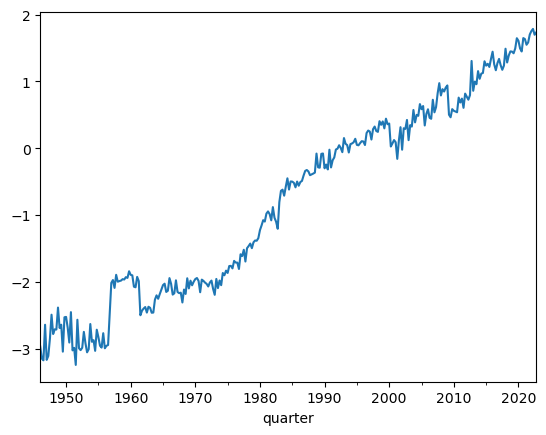

In [6]:
log_dividends.plot();
print("ADF test results for the dividends paid by S&P 500 stocks:")
display(adfuller(log_dividends))
print("KPSS test results for the dividends paid by S&P 500 stocks:")
display(kpss(log_dividends))

Firstly, the dividends paid by S&P 500 stocks follows a random walk so that there is a strong trend in the plot. Besides, we see that the p-value in the ADF test is 0.97, which is greater than 0.05. That means we already believe the series has a unit root, and the computer confirms that we are right. The p-value in the KPSS test is 0.01, and the warning states that the actual p-value is smaller than the p-value returned. That indicates we already believe the data are stationary, but there is clear evidence to change our mind from the p-value is less than 0.01, which is also less than 0.05.

### Series No.4

ADF test results for the percentage growth of S&P 500 dividend payments:


(-7.975252125776361,
 2.713259613957287e-12,
 6,
 300,
 {'1%': -3.4523371197407404,
  '5%': -2.871222860740741,
  '10%': -2.571929211111111},
 -366.5976517891311)

KPSS test results for the percentage growth of S&P 500 dividend payments:


/var/folders/m5/g3lrdtg540gfc8q3_268l1800000gn/T/ipykernel_14261/1327414230.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  display(kpss(log_dividends_growth))


(0.09738433517705765,
 0.1,
 34,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

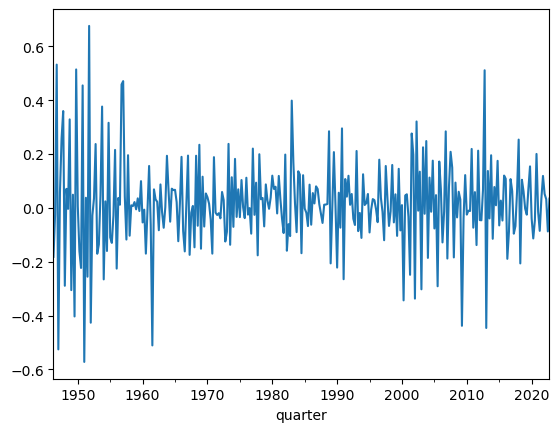

In [7]:
log_dividends_growth.plot();
print("ADF test results for the percentage growth of S&P 500 dividend payments:")
display(adfuller(log_dividends_growth))
print("KPSS test results for the percentage growth of S&P 500 dividend payments:")
display(kpss(log_dividends_growth))

Firstly, the percentage growth of S&P 500 dividend payments is stationary, so there is no trend in the plot. Besides, we see that the p-value in the ADF test is nearly 0, which is smaller than 0.05. That means we already believe the series has a unit root, but there is clear evidence to change our minds. The p-value in the KPSS test is 0.1, and the warning states that the actual p-value is greater than the p-value returned. That indicates we already believe the data are stationary, and the computer confirms that we are right from the p-value is greater than 0.1, which is also greater than 0.05.

### Series No.5

ADF test results for the S&P 500 dividend yield:


(-2.9051472997290193,
 0.04475270237473014,
 7,
 300,
 {'1%': -3.4523371197407404,
  '5%': -2.871222860740741,
  '10%': -2.571929211111111},
 -254.9551357803051)

KPSS test results for the S&P 500 dividend yield:


(0.5595794067166489,
 0.028247881370124125,
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

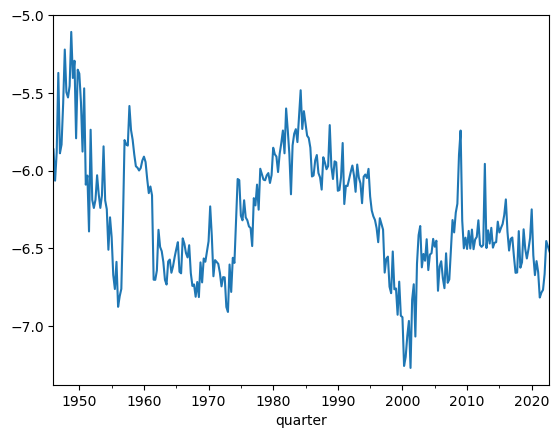

In [8]:
log_DP.plot();
print("ADF test results for the S&P 500 dividend yield:")
display(adfuller(log_DP))
print("KPSS test results for the S&P 500 dividend yield:")
display(kpss(log_DP))

In [9]:
print( ols("log_DP ~ log_DP.shift()",data=log_DP).fit().summary() )

                            OLS Regression Results                            
Dep. Variable:                 log_DP   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     1110.
Date:                Tue, 07 Nov 2023   Prob (F-statistic):          1.14e-103
Time:                        14:30:26   Log-Likelihood:                 92.514
No. Observations:                 307   AIC:                            -181.0
Df Residuals:                     305   BIC:                            -173.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.7283      0.167     -4.

In [13]:
ols("log_DP.diff() ~ log_DP.shift()",data=log_DP).fit().tvalues['log_DP.shift()']

-4.351044599768743

In [23]:
ols("log_DP.diff() ~ log_DP.shift() + log_DP.diff().shift() + log_DP.diff().shift(2)",data=log_DP).fit().tvalues['log_DP.shift()']

-2.5895551157022147

In [28]:
ols("log_DP.diff() ~ log_DP.shift() + log_DP.diff().shift() + log_DP.diff().shift(2) + log_DP.diff().shift(3)+ log_DP.diff().shift(4) + log_DP.diff().shift(5) + log_DP.diff().shift(6) + log_DP.diff().shift(7)",data=log_DP).fit().tvalues['log_DP.shift()']

-2.9051472997291006

In [30]:
display(adfuller(log_DP,maxlag=10,autolag='t-stat'))
display(adfuller(log_DP))


(-2.9051472997290193,
 0.04475270237473014,
 7,
 300,
 {'1%': -3.4523371197407404,
  '5%': -2.871222860740741,
  '10%': -2.571929211111111},
 3.4273293687936293)

(-2.9051472997290193,
 0.04475270237473014,
 7,
 300,
 {'1%': -3.4523371197407404,
  '5%': -2.871222860740741,
  '10%': -2.571929211111111},
 -254.9551357803051)

From the previous code, I found that when use the maxlag=0 in statsmodels, we cannot find anything, since both p-value of ADF test and KPSS test below 0.05. This means we cannot draw any conclusion via this. So, let's consider the maxlag is greater than 0. When we do more lag for the regression, both lag=2, and lag=3, the t-values are the same, that indicates the data is hard to tell, when there is 7 lag.